In [1]:
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn3
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from scipy import stats
import statsmodels.api as sm
from patsy import dmatrix, dmatrices

# Relationship between class and constraint

In [4]:
# Load classification of GPCRs
gpcr_classes = pd.read_csv('../data/GuideToPharm_targets/GPCRdb_class_by_gpcr.csv')
# Load expression levels across tissues 
gpcr_expression = pd.read_csv('../data/HPA_tissue_expression/filtered_protein_expression_by_tissue.csv',index_col=0)
# Precomputed constraint metrics from gnomAD
gpcr_constraint = pd.read_csv('../data/gnomAD_population_variants/gnomad_v2.1.1_gpcr_precomputed_constraint.csv',index_col=0)

In [4]:
gpcr_constraint_by_class = gpcr_classes.merge(gpcr_constraint,on='HGNC symbol')
gpcr_constraint_by_class.head()

,HGNC symbol,common_name,Uniprot_name,Uniprot_accession,GPCRdb_stub,Ensembl_gene_id,alt_gene_symbols,Class,Ligand_type,Family,...,gene_type,gene_length,exac_pLI,exac_obs_lof,exac_exp_lof,exac_oe_lof,brain_expression,chromosome,start_position,end_position
0,ACKR1,ACKR1,ACKR1_HUMAN,Q16570,001_003_002_019,ENSG00000213088,"['ACKR1', 'DARC', 'FY', 'GPD']",A,Protein,Chemokine,...,protein_coding,3194,0.000274,5.0,4.3035,1.16190,NaN,1,159173097,159176290
1,ACKR2,ACKR2,ACKR2_HUMAN,O00590,001_003_002_020,ENSG00000144648,"['ACKR2', 'CCBP2', 'CCR10', 'CMKBR9', 'D6']",A,Protein,Chemokine,...,protein_coding,83223,0.000377,5.0,4.7509,1.05240,NaN,3,42846244,42929466
2,ACKR3,ACKR3,ACKR3_HUMAN,P25106,001_003_002_021,ENSG00000144476,"['ACKR3', 'CMKOR1', 'CXCR7', 'GPR159', 'RDC1']",A,Protein,Chemokine,...,protein_coding,14572,0.419560,1.0,4.9778,0.20089,NaN,2,237476430,237491001
3,ACKR4,ACKR4,ACKR4_HUMAN,Q9NPB9,001_003_002_022,ENSG00000129048,"['ACKR4', 'CCBP2', 'CCR11', 'CCRL1', 'VSHK1']",A,Protein,Chemokine,...,protein_coding,21731,0.007445,4.0,6.4933,0.61602,NaN,3,132316081,132337811
4,ADCYAP1R1,PAC<sub>1</sub> receptor,PACR_HUMAN,P41586,002_001_005_001,ENSG00000078549,['ADCYAP1R1'],B1,Peptide,VIP and PACAP,...,protein_coding,59014,0.001335,9.0,23.2660,0.38682,NaN,7,31092076,31151089


In [145]:
gpcr_expression_tidy = pd.melt(gpcr_expression,id_vars='gene',var_name='tissue',value_name='expression_level')
gpcr_expression_tidy['expression_level_ordinal'] = gpcr_expression_tidy['expression_level'].map({
    'Not detected':0,
    'Low':1,
    'Medium':2,
    'High':3
})

In [160]:
gpcr_expression_tidy.tissue.unique()

array(['adipose tissue', 'adrenal gland', 'appendix', 'bone marrow',
       'breast', 'bronchus', 'caudate', 'cerebellum', 'cerebral cortex',
       'cervix, uterine', 'colon', 'duodenum', 'endometrium 1',
       'endometrium 2', 'epididymis', 'esophagus', 'fallopian tube',
       'gallbladder', 'heart muscle', 'hippocampus', 'kidney', 'liver',
       'lung', 'lymph node', 'nasopharynx', 'oral mucosa', 'ovary',
       'pancreas', 'parathyroid gland', 'placenta', 'prostate', 'rectum',
       'salivary gland', 'seminal vesicle', 'skeletal muscle', 'skin 1',
       'skin 2', 'small intestine', 'smooth muscle', 'soft tissue 1',
       'soft tissue 2', 'spleen', 'stomach 1', 'stomach 2', 'testis',
       'thyroid gland', 'tonsil', 'urinary bladder', 'vagina'],
      dtype=object)

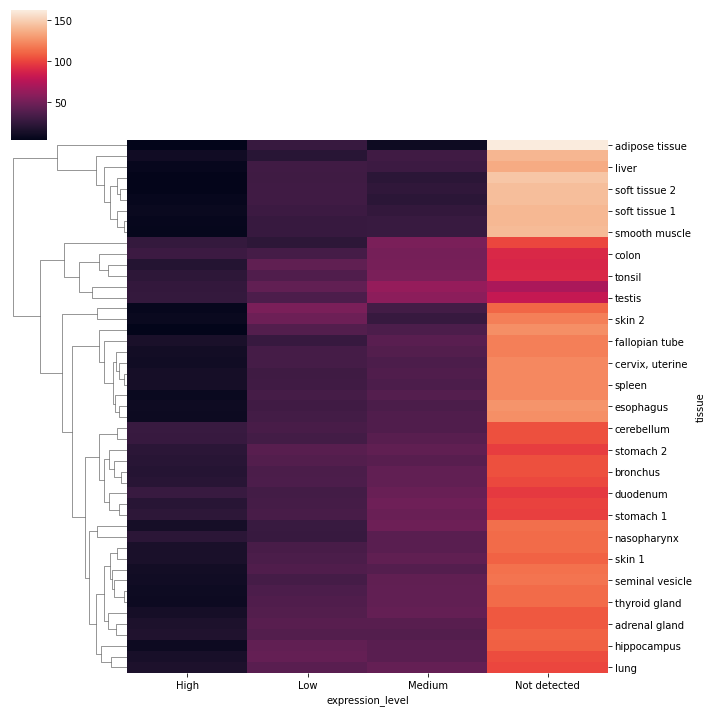

In [180]:
sns.clustermap(gpcr_expression_tidy.pivot_table(index='tissue',columns = 'expression_level',values='expression_level_ordinal',aggfunc='count'),col_cluster=False)
#sns.scatterplot(data=gpcr_expression_tidy,x='tissue',y='expression_level_ordinal')

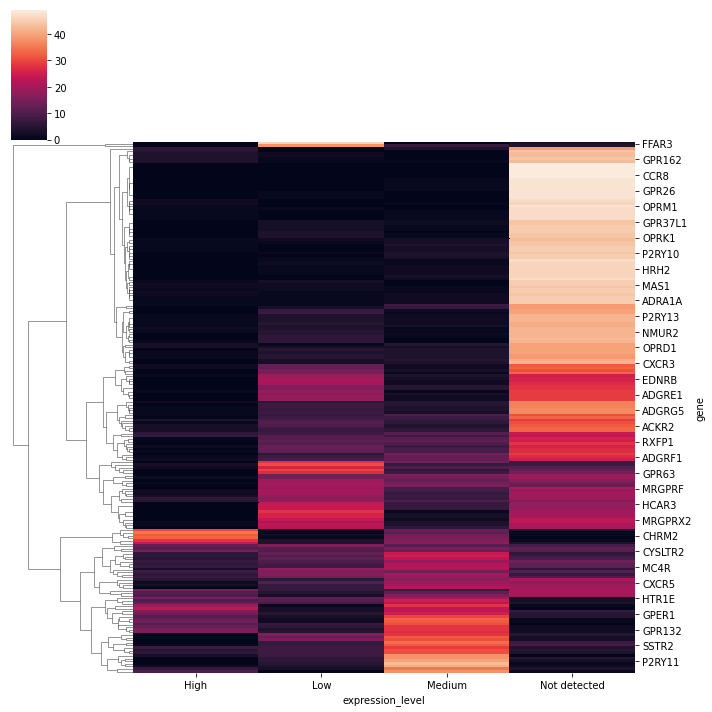

In [179]:
sns.clustermap(gpcr_expression_tidy.pivot_table(index='gene',columns = 'expression_level',values='expression_level_ordinal',aggfunc='count',fill_value=0),col_cluster=False)
#sns.scatterplot(data=gpcr_expression_tidy,x='tissue',y='expression_level_ordinal')

<AxesSubplot:xlabel='expression_level_ordinal', ylabel='oe_mis_upper'>

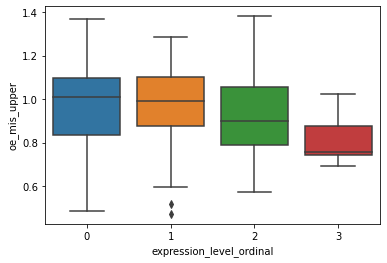

In [213]:
median_expression = gpcr_expression_tidy.groupby('gene').agg({'expression_level_ordinal':lambda x: np.median(x)}).reset_index()
gpcr_constraint_by_class_and_tissue = gpcr_constraint_by_class.merge(median_expression,left_on='HGNC symbol',right_on='gene')
sns.boxplot(data=gpcr_constraint_by_class_and_tissue,x='expression_level_ordinal',y='oe_mis_upper')

In [219]:
gpcr_expression_tidy[gpcr_expression_tidy.tissue=='heart muscle']

,gene,tissue,expression_level,expression_level_ordinal
3654,ACKR1,heart muscle,Not detected,0
3655,ACKR2,heart muscle,Not detected,0
3656,ACKR3,heart muscle,Low,1
3657,ADCYAP1R1,heart muscle,Not detected,0
3658,ADGRA1,heart muscle,Not detected,0
...,...,...,...,...
3852,TPRA1,heart muscle,Medium,2
3853,TRHR,heart muscle,Not detected,0
3854,TSHR,heart muscle,Not detected,0
3855,VIPR1,heart muscle,Medium,2


In [214]:
y1, X1 = dmatrices('oe_mis_upper ~ expression_level_ordinal',data=gpcr_constraint_by_class_and_tissue,NA_action='drop')
mod1 = sm.OLS(y1, X1)
res1 = mod1.fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           oe_mis_upper   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     3.677
Date:                Mon, 15 Mar 2021   Prob (F-statistic):             0.0566
Time:                        17:19:04   Log-Likelihood:                 59.846
No. Observations:                 203   AIC:                            -115.7
Df Residuals:                     201   BIC:                            -109.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.9753      0.016     60.990      0.000       0.944       1.007
expression_level_ordinal    -0.0276      0.014     -1.918      0.057      -0.056       0.001
==============================================================================
Omnibus:                        1.620   Durbin-Watson:                   1.639
Prob(Omnibus):                  0.445   Jarque-Bera (JB):                1.677
Skew:                          -0.209   Prob(JB):                        0.432
Kurtosis:                       2.847   Cond. No.                         2.04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [150]:
num_tissues = gpcr_expression_tidy.groupby('gene').agg({'expression_level_ordinal': lambda x: sum(x>0)}).reset_index()

In [201]:
gpcr_constraint_by_class_and_tissue = gpcr_constraint_by_class.merge(num_tissues,left_on='HGNC symbol',right_on='gene')

Start by plotting the data - use strip plots to show number + distribution

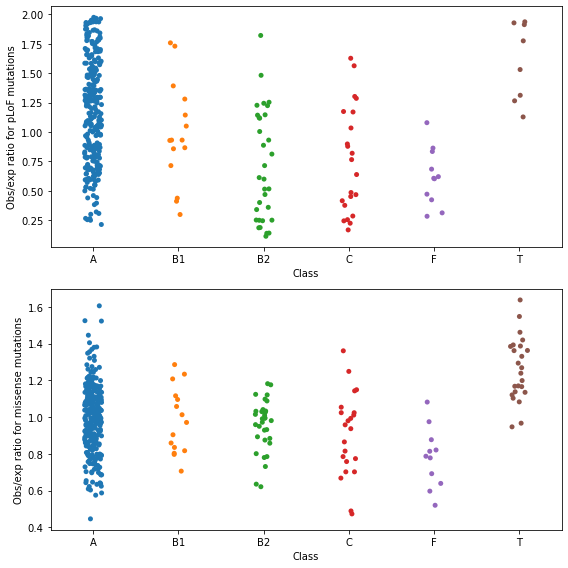

In [5]:
fig, (ax1,ax2) = plt.subplots(2,figsize=(8,8))
sns.stripplot(data=gpcr_constraint_by_class[gpcr_constraint_by_class.Class!='Other'],y='oe_lof_upper',x='Class',hue='Class',ax=ax1,jitter=0.1)
ax1.set_ylabel('Obs/exp ratio for pLoF mutations')
ax1.get_legend().remove()
sns.stripplot(data=gpcr_constraint_by_class[gpcr_constraint_by_class.Class!='Other'],y='oe_mis_upper',x='Class',hue='Class',ax=ax2,jitter=0.1)
ax2.set_ylabel('Obs/exp ratio for missense mutations')
ax2.get_legend().remove()
plt.tight_layout()
plt.savefig('../plots/constraint_by_class.png',dpi=250)

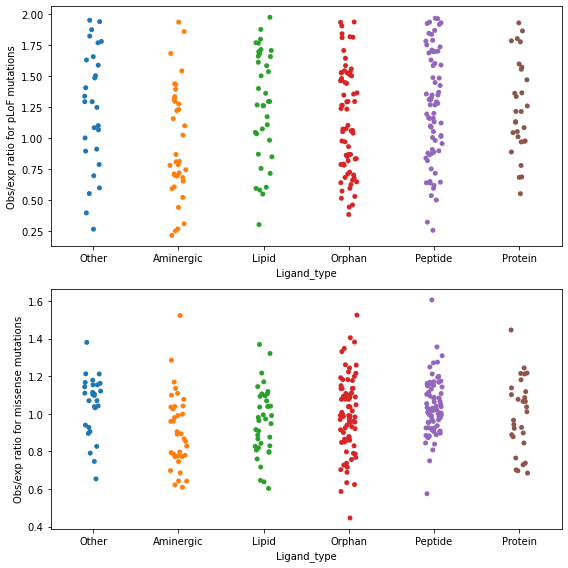

In [61]:
ClassA = gpcr_constraint_by_class[
    (gpcr_constraint_by_class.Class=='A')
].sort_values('Ligand_type')
ClassA_ligand_type = ClassA['Ligand_type'].copy()
ClassA_ligand_type[~ClassA_ligand_type.isin(['Aminergic','Peptide','Protein','Lipid','Orphan'])] = 'Other'

fig, (ax1,ax2) = plt.subplots(2,figsize=(8,8))
sns.stripplot(data=ClassA,y='oe_lof_upper',x=ClassA_ligand_type,hue=ClassA_ligand_type,ax=ax1,jitter=0.1)
ax1.set_ylabel('Obs/exp ratio for pLoF mutations')
ax1.get_legend().remove()
sns.stripplot(data=ClassA,y='oe_mis_upper',x=ClassA_ligand_type,hue=ClassA_ligand_type,ax=ax2,jitter=0.1)
ax2.set_ylabel('Obs/exp ratio for missense mutations')
ax2.get_legend().remove()
plt.tight_layout()
plt.savefig('../plots/constraint_by_ligand_type_classA.png',dpi=250)

In [119]:
ClassA = gpcr_constraint_by_class[
    (gpcr_constraint_by_class.Class=='A')
].sort_values('Ligand_type')
ClassA_count_by_family = ClassA.groupby('Family').agg({'HGNC symbol':len})
ClassA_singleton_families = ClassA_count_by_family[ClassA_count_by_family['HGNC symbol'] < 3].index
ClassA_families = ClassA['Family'].copy()
ClassA_family_ligand_types = ClassA['Ligand_type'].copy()
ClassA_families[ClassA_families.isin(ClassA_singleton_families)] = 'Other'
ClassA_family_ligand_types[ClassA_families == 'Other'] = 'Other'

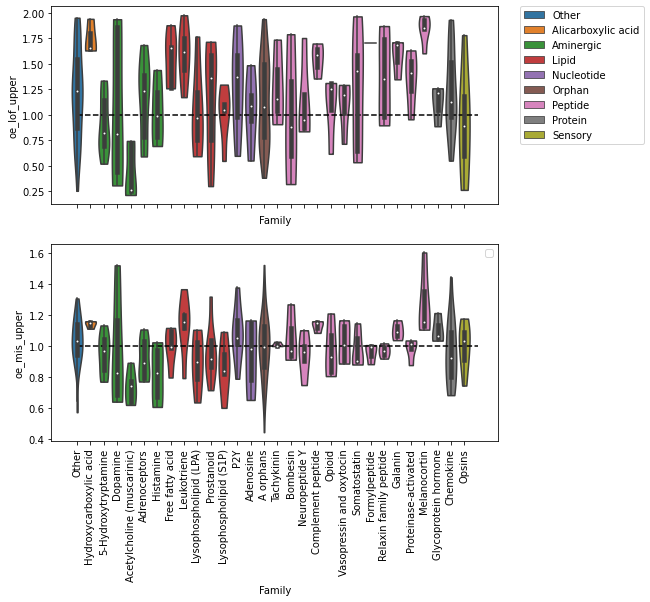

In [134]:
fig, (ax1,ax2) = plt.subplots(2,figsize=(8,8))
sns.violinplot(data=ClassA,x=ClassA_families,y='oe_lof_upper',hue=ClassA_family_ligand_types,ax=ax1,dodge=False,cut=0)
sns.violinplot(data=ClassA,x=ClassA_families,y='oe_mis_upper',hue=ClassA_family_ligand_types,ax=ax2,dodge=False,cut=0)

ax1.set_xticklabels([])#ax1.get_xticklabels(),rotation=90)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)
ax1.hlines(1,0,30,colors='k',linestyles='dashed')
ax2.hlines(1,0,30,colors='k',linestyles='dashed')
# Put the legend out of the figure
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax2.legend([])

In [54]:
# Ordinal regression for rank of upper bound of obs/exp for LoF mutations
y1 = gpcr_constraint_by_class[gpcr_constraint_by_class.Class!='Other']['oe_lof_upper'][~gpcr_constraint_by_class['oe_lof_upper'].isna()].rank()
X1 = dmatrix('C(Class)',data=gpcr_constraint_by_class[gpcr_constraint_by_class.Class!='Other'][~gpcr_constraint_by_class['oe_lof_upper'].isna()])
mod1 = sm.OLS(y1, X1,)
res1 = mod1.fit()
res1.summary()

<ipython-input-54-7ed7515393ce>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X1 = dmatrix('C(Class)',data=gpcr_constraint_by_class[gpcr_constraint_by_class.Class!='Other'][~gpcr_constraint_by_class['oe_lof_upper'].isna()])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           oe_lof_upper   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     13.58
Date:                Wed, 10 Mar 2021   Prob (F-statistic):           3.92e-12
Time:                        10:19:08   Log-Likelihood:                -2150.9
No. Observations:                 360   AIC:                             4314.
Df Residuals:                     354   BIC:                             4337.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        198.2114      5.821     34.053      0.000     186.764     209.659
x1           -43.3781     25.460     -1.704      0.089     -93.451       6.695
x2           -97.0083     17.940     -5.407      0.000    -132.292     -61.725
x3           -89.2569     21.278     -4.195      0.000    -131.104     -47.409
x4          -124.5296     29.524     -4.218      0.000    -182.593     -66.466
x5            89.0386     34.435      2.586      0.010      21.315     156.762
==============================================================================
Omnibus:                       92.603   Durbin-Watson:                   1.641
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.852
Skew:                           0.004   Prob(JB):                     0.000219
Kurtosis:                       1.940   Cond. No.                         6.89
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

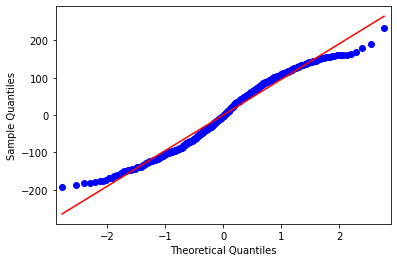

In [55]:
_ = sm.graphics.qqplot(res1.resid,line='r')

In [56]:
# Standard OLS regression for upper bound of obs/exp for missense mutations
y2, X2 = dmatrices('oe_mis_upper ~ C(Class)',data=gpcr_constraint_by_class[gpcr_constraint_by_class.Class!='Other'])
mod2 = sm.OLS(y2, X2)
res2 = mod2.fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           oe_mis_upper   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     14.69
Date:                Wed, 10 Mar 2021   Prob (F-statistic):           3.52e-13
Time:                        10:20:19   Log-Likelihood:                 111.87
No. Observations:                 387   AIC:                            -211.7
Df Residuals:                     381   BIC:                            -188.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.9963      0.011     91.760      0.000       0.975       1.018
C(Class)[T.B1]    -0.0161      0.048     -0.332      0.740      -0.111       0.079
C(Class)[T.B2]    -0.0418      0.034     -1.228      0.220      -0.109       0.025
C(Class)[T.C]     -0.0911      0.040     -2.253      0.025      -0.171      -0.012
C(Class)[T.F]     -0.2161      0.056     -3.850      0.000      -0.326      -0.106
C(Class)[T.T]      0.2657      0.039      6.843      0.000       0.189       0.342
==============================================================================
Omnibus:                        0.838   Durbin-Watson:                   1.502
Prob(Omnibus):                  0.658   Jarque-Bera (JB):                0.615
Skew:                           0.012   Prob(JB):                        0.735
Kurtosis:                       3.194   Cond. No.                         6.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

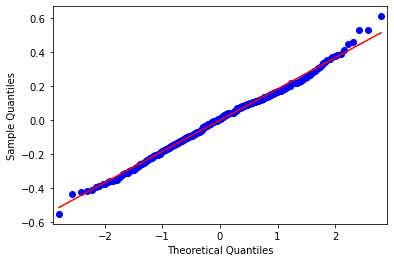

In [57]:
_ = sm.graphics.qqplot(res2.resid,line='r')

In [26]:
# Standard OLS regression for upper bound of obs/exp for missense mutations
y2 = ClassA['oe_mis_upper']
X2 = dmatrix('C(Ligand_type)',pd.DataFrame(ClassA_ligand_type,columns=['Ligand_type']))
X2
# mod2 = sm.OLS(y2, X2)
# res2 = mod2.fit()
# res2.summary()

DesignMatrix with shape (283, 6)
  Columns:
    ['Intercept',
     'C(Ligand_type)[T.Lipid]',
     'C(Ligand_type)[T.Orphan]',
     'C(Ligand_type)[T.Other]',
     'C(Ligand_type)[T.Peptide]',
     'C(Ligand_type)[T.Protein]']
  Terms:
    'Intercept' (column 0), 'C(Ligand_type)' (columns 1:6)
  (to view full data, use np.asarray(this_obj))

In [6]:
ClassA_ligand_type_nonorphan = gpcr_constraint_by_class[
    (gpcr_constraint_by_class.Class=='A') & 
    (gpcr_constraint_by_class.Ligand_type!='Orphan')
].sort_values('Ligand_type')

In [42]:
(gpcr_constraint_by_class.groupby(['Class','Ligand_type'])
                         .agg({'oe_mis_upper':[np.mean,np.std],
                               'oe_lof_upper':[np.mean,np.std]}))

oe_mis_upper           oe_lof_upper          
                                 mean       std         mean       std
Class Ligand_type                                                     
A     Alicarboxylic acid     1.127600  0.028510     1.612400  0.246847
      Aminergic              0.910833  0.199376     0.954556  0.454877
      Lipid                  0.954568  0.180874     1.267541  0.443356
      Melatonin              1.158500  0.075660     1.531000  0.336583
      Nucleotide             1.035000  0.202808     1.221167  0.427440
      Orphan                 0.999654  0.200673     1.139536  0.428288
      Peptide                1.036027  0.150040     1.245452  0.443733
      Protein                0.993172  0.193586     1.243138  0.379125
      Sensory                0.996143  0.148611     0.927714  0.521342
      Steroid                1.004500  0.139300     1.323000  0.888126
B1    Peptide                0.980200  0.180722     0.981800  0.435020
B2    Adhesion               0.954437  0.140277     0.709156  0.466739
C     Amino acid             0.756500  0.199237     0.425800  0.297220
      Ion                    0.702000       NaN     0.451000       NaN
      Orphan                 1.014125  0.111266     0.973750  0.354026
      Sensory                1.178000  0.170361     1.341000  0.200247
F     Protein                0.780182  0.164390     0.616091  0.242779
Other Orphan                 0.958200  0.127527     0.624000  0.340152
T     Sensory                1.262000  0.172961     1.598625  0.332189

In [49]:
#with pd.set_option('display.max_rows', 100):
(gpcr_constraint_by_class[gpcr_constraint_by_class.Class=='A'].groupby(['Ligand_type','Family'])
                             .agg({'oe_mis_upper':[np.mean,np.std],
                               'oe_lof_upper':[np.mean,np.std]}))

oe_mis_upper            \
                                                           mean       std   
Ligand_type        Family                                                   
Alicarboxylic acid Hydroxycarboxylic acid              1.143333  0.025716   
                   Oxoglutarate                        1.110000       NaN   
                   Succinate                           1.098000       NaN   
Aminergic          5-Hydroxytryptamine                 0.950833  0.126231   
                   Acetylcholine (muscarinic)          0.736600  0.110389   
                   Adrenoceptors                       0.918889  0.128967   
                   Dopamine                            0.969800  0.371873   
                   Histamine                           0.823250  0.201162   
                   Trace amine                         1.285000       NaN   
Lipid              Cannabinoid                         0.813500  0.236881   
                   Free fatty acid                     1.000000  0.126376   
                   GPR18 GPR55 and GPR119              1.036000       NaN   
                   GPR18 GPR55 and GPR120              0.973000       NaN   
                   GPR18 GPR55 and GPR121              0.830000       NaN   
                   Leukotriene                         1.133667  0.189333   
                   Lysophospholipid (LPA)              0.895000  0.178748   
                   Lysophospholipid (S1P)              0.861200  0.180309   
                   Platelet-activating factor          0.827000       NaN   
                   Prostanoid                          0.949778  0.174032   
Melatonin          Melatonin                           1.158500  0.075660   
Nucleotide         Adenosine                           0.948000  0.249969   
                   P2Y                                 1.078500  0.177110   
Orphan             A orphans                           0.999654  0.200673   
Peptide            Angiotensin                         1.102000  0.097581   
                   Apelin                              0.960000       NaN   
                   Bombesin                            1.051000  0.192429   
                   Bradykinin                          1.034000  0.154149   
                   Cholecystokinin                     1.020000  0.043841   
                   Complement peptide                  1.133667  0.040723   
                   Endothelin                          0.736000  0.227688   
                   Formylpeptide                       0.963000  0.067816   
                   Galanin                             1.100667  0.064260   
                   Ghrelin                             1.080000       NaN   
                   Gonadotrophin-releasing hormone     1.067000       NaN   
                   Kisspeptin                          0.937000       NaN   
                   Melanin-concentrating hormone       1.133000  0.164049   
                   Melanocortin                        1.271600  0.211284   
                   Motilin                             0.994000       NaN   
                   Neuromedin U                        1.111000  0.067882   
                   Neuropeptide FF/neuropeptide AF     1.074000  0.332340   
                   Neuropeptide S                      1.199000       NaN   
                   Neuropeptide W/neuropeptide B       1.140000  0.190919   
                   Neuropeptide Y                      0.944750  0.146131   
                   Neurotensin                         1.082500  0.129401   
                   Opioid                              0.972250  0.185588   
                   Orexin                              0.899500  0.037477   
                   Peptide P518                        1.084000       NaN   
                   Prolactin-releasing peptide         1.194000       NaN   
                   Proteinase-activated                0.988000  0.073335   
                   Relaxin family peptide      

In [10]:
model = sm.MixedLM.from_formula(
    'oe_mis_upper ~ 1',
    data=ClassA_ligand_type_nonorphan,
    groups='Family'
)
fit = model.fit(method=["lbfgs"])
fit.summary()

/home/andrew/miniconda3/envs/variants/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2168: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
==========================================================
Model:            MixedLM Dependent Variable: oe_mis_upper
No. Observations: 205     Method:             REML        
No. Groups:       61      Scale:              0.0319      
Min. group size:  1       Log-Likelihood:     59.3964     
Max. group size:  23      Converged:          Yes         
Mean group size:  3.4                                     
-----------------------------------------------------------
             Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept    0.995     0.013  75.006  0.000   0.969   1.021
Family Var   0.000     0.006                               
==========================================================

"""

In [30]:
model = sm.MixedLM.from_formula(
    'oe_lof_upper ~ 1',
    data=gpcr_constraint_by_class,
    groups='Class',
    missing='drop'
)
fit = model.fit(method=["lbfgs"])
fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
==========================================================
Model:            MixedLM Dependent Variable: oe_lof_upper
No. Observations: 365     Method:             REML        
No. Groups:       7       Scale:              0.1948      
Min. group size:  5       Log-Likelihood:     -228.7837   
Max. group size:  272     Converged:          Yes         
Mean group size:  52.1                                    
-----------------------------------------------------------
              Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept     0.926     0.131  7.083  0.000   0.670   1.182
Class Var     0.105     0.164                              
==========================================================

"""

In [50]:
model = sm.MixedLM.from_formula(
    'oe_mis_upper ~ 1',
    data=gpcr_constraint_by_class,
    groups='Class',
)
fit = model.fit(method=["lbfgs"])
fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
==========================================================
Model:            MixedLM Dependent Variable: oe_mis_upper
No. Observations: 392     Method:             REML        
No. Groups:       7       Scale:              0.0332      
Min. group size:  5       Log-Likelihood:     100.3115    
Max. group size:  283     Converged:          Yes         
Mean group size:  56.0                                    
-----------------------------------------------------------
             Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept    0.979     0.056  17.641  0.000   0.871   1.088
Class Var    0.019     0.068                               
==========================================================

"""

156


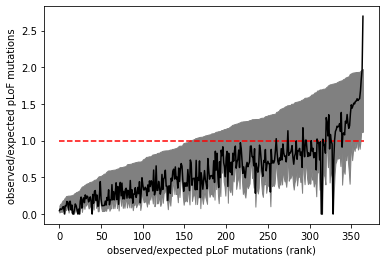

In [55]:
gpcr_constraint = gpcr_constraint.sort_values(by='oe_lof_upper')
x = np.arange(len(gpcr_constraint))
plt.plot(x,gpcr_constraint['oe_lof'].values,'k-')
plt.fill_between(x, gpcr_constraint['oe_lof_lower'], gpcr_constraint['oe_lof_upper'],color='grey')
plt.hlines(1,0,len(gpcr_constraint_nonan),'r',linestyles='dashed')
plt.xlabel('observed/expected pLoF mutations (rank)')
plt.ylabel('observed/expected pLoF mutations')
print((gpcr_constraint['oe_lof_upper']<1).sum())
plt.savefig('../plots/oe_plof_gnomad_summary_stats.png',dpi=100)

197


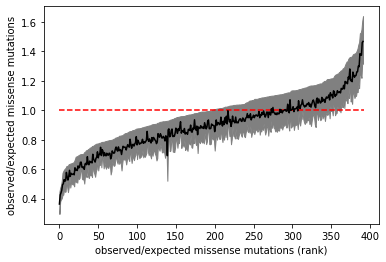

In [9]:
gpcr_constraint_mis = gpcr_constraint.sort_values(by='oe_mis_upper')
x = np.arange(len(gpcr_constraint_mis))
plt.plot(x,gpcr_constraint_mis['oe_mis'].values,'k-')
plt.fill_between(x, gpcr_constraint_mis['oe_mis_lower'], gpcr_constraint_mis['oe_mis_upper'],color='grey')
plt.hlines(1,0,len(gpcr_constraint),'r',linestyles='dashed')
plt.xlabel('observed/expected missense mutations (rank)')
plt.ylabel('observed/expected missense mutations')
print((gpcr_constraint_mis['oe_mis_upper']<1).sum())
plt.savefig('../plots/oe_missense_gnomad_summary_stats.png',dpi=100)

(0.9162597921319999, 4.950413375456214e-157)


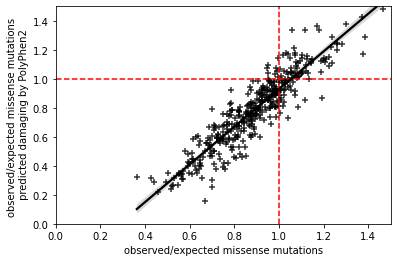

In [12]:
gpcr_constraint_pp = gpcr_constraint.sort_values('oe_mis_pphen')
#plt.subplots(figsize=(5,5))
sns.regplot(
    data= gpcr_constraint_mis,
    x='oe_mis',
    y='oe_mis_pphen',
    color='black',
    marker='+'
)
plt.xlim((0,1.5))
plt.ylim((0,1.5))
plt.hlines(1,0,1.5,color='red',linestyles='dashed')
plt.vlines(1,0,1.5,color='red',linestyles='dashed')
plt.xlabel('observed/expected missense mutations')
plt.ylabel('observed/expected missense mutations \n predicted damaging by PolyPhen2')
print(stats.pearsonr(gpcr_constraint['oe_mis'],gpcr_constraint['oe_mis_pphen']))
plt.savefig('../plots/oe_missense_pphen_gnomad_summary_stats.png',dpi=100)

(0.6479099197197811, 7.936534175190781e-45)


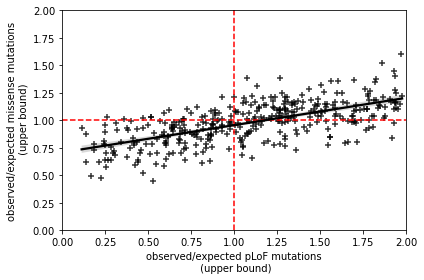

In [114]:
sns.regplot(
    data=gpcr_constraint,
    x='oe_lof_upper',
    y='oe_mis_upper',
    color='black',
    marker='+'
)
plt.xlim((0,2))
plt.ylim((0,2))
plt.hlines(1,0,2,color='red',linestyles='dashed')
plt.vlines(1,0,2,color='red',linestyles='dashed')
print(stats.pearsonr(gpcr_constraint_nonan['oe_lof_upper'].values,gpcr_constraint_nonan['oe_mis_upper'].values))
plt.xlabel('observed/expected pLoF mutations\n (upper bound)')
plt.ylabel('observed/expected missense mutations\n (upper bound)')
plt.tight_layout()
plt.savefig('../plots/oe_plof_mis_scatter_gnomad_summary_stats.png')

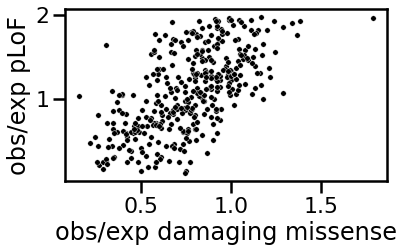

In [18]:
sns.set_context('poster')
sns.scatterplot(data=gpcr_constraint,x='oe_mis_pphen',y='oe_lof_upper',color='k',s=30)
#print(pearsonr(gpcr_constraint_omim_nonan['oe_lof'].values,gpcr_constraint_omim_nonan['oe_mis_pphen'].values))
plt.ylabel('obs/exp pLoF')
plt.xlabel('obs/exp damaging missense')
plt.tight_layout()
plt.savefig('../plots/oe_plof_mis_pphen_scatter.png',dpi=100)